This code is a modification of the one available at:

https://nbviewer.org/urls/arteagac.github.io/blog/lime.ipynb

Code created by Rafael Solar in Google colab.
This program aims to implement the LIME system (Local Interpretable Model-agnostic Explanations) (Ribeiro et al, 2016).


In [ ]:
# Connect to our files in Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import copy
import skimage.io
import skimage.segmentation
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression


In [ ]:
# We call the classification model that will be used.
model = tf.keras.models.load_model('...model5animals.h5')

In [ ]:
def perturb_image(img,perturbation,segments):
  """
  This function returns the original image by activating and deactivating the superpixels of the original image.

  Input:
  -img: The original image.
  -perturbation: A binary vector (0 or 1) that indicates which superpixels of the image should be perturbed.
  -segments: An array that divides the image into segments, where each value represents a different superpixel.
  Output:

  -perturbed_image: Returns the perturbed image.
  """
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

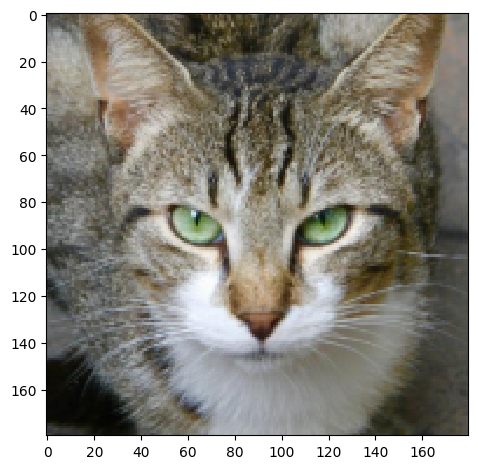

In [ ]:
url_img = '...cat.1550.jpg'
# Preprocess the input image
Xi = skimage.io.imread(url_img)
Xi = skimage.transform.resize(Xi, (180,180))
Xi = (Xi - 0.5)*2 
skimage.io.imshow(Xi/2+0.5)

In [ ]:
# Predict the class of the input image
preds = model.predict(Xi[np.newaxis,:,:,:])
#decode_predictions(preds)[0] #Top 5 classes
top_pred_classes = preds[0].argsort()[-2:][::-1]
# Extract the superpixels from the image
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=3,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]

1/1 [==============================] - 0s 36ms/step


49

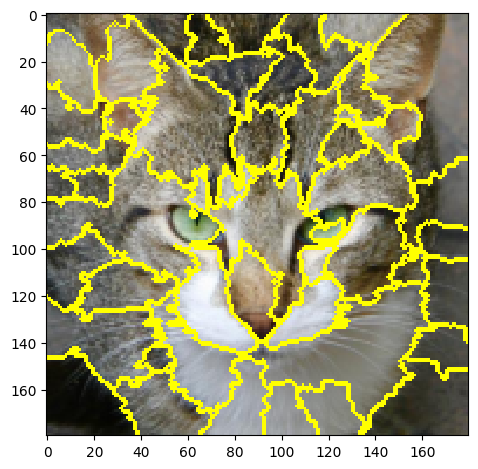

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

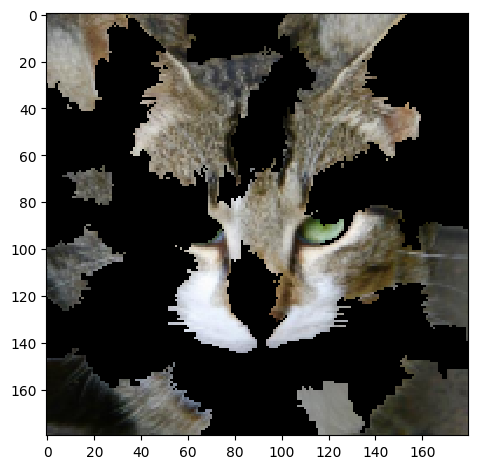

In [ ]:
# Create random perturbations
num_perturb = 400
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [ ]:
# Use the classifier to predict the classes of the newly generated images
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = model.predict(perturbed_img[np.newaxis,:,:,:],verbose=False)
  predictions.append(pred)
predictions = np.array(predictions)

In [ ]:
# Calculate distances between the original image and each perturbed image, and compute weights (importance) for each perturbed image

original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled
distances = sklearn.metrics.pairwise_distances(perturbations, original_image, metric='cosine').ravel()
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances ** 2) / kernel_width ** 2))

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


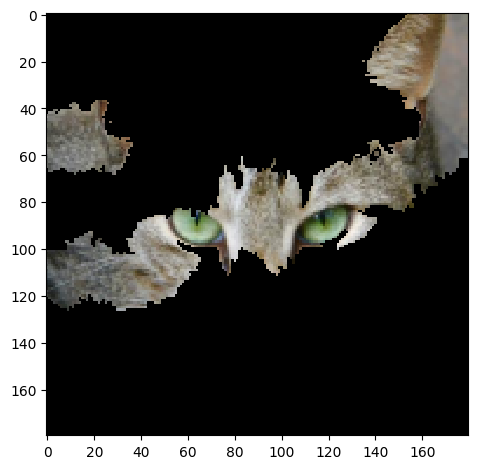

In [ ]:
# Use perturbations, predictions, and weights to train a linear regression model
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
# Calculate key features (superpixels)
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:]

# Display the LIME explanation
mask = np.zeros(num_superpixels)
mask[top_features]= True #Activate top superpixels
img = perturb_image(Xi/2+0.5,mask,superpixels)
skimage.io.imshow(img)